# SPISEA: Making a Cluster with BD Candidates

This is a document to generate a synthetic cluster in SPISEA with the addition of brown dwarf candidates. It will follow the Quick Start Guide closely, but with changes due to a lower mass limit and ability to consider smaller objects.

In [1]:
# Import necessary packages. 
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

### 1: Making an Isochrone Object for our Cluster

In [ ]:
# Define isochrone parameters
logAge = np.log10(5*10**6.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec
metallicity = 0 # Metallicity in [M/H]

# Define evolution/atmosphere models and extinction law
evo_model = evolution.MergedBaraffePisaEkstromParsec() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Specify the directory we want the output isochrone
# table saved in. If the directory does not already exist,
# SPISEA will create it.
iso_dir = 'isochrones/'

# Make IsochronePhot object. Note that this will take a minute or two, 
# unless the isochrone has been generated previously.
#
# Note that this is not show all of the user options 
# for IsochronePhot. See docs for complete list of options.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=0,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)

In [ ]:
# The stars in the isochrone and associated properties  
# are stored in an astropy table called "points" 
# within the IsochronePhot object. 
print(my_iso.points)

In [ ]:
# Example case:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

In [ ]:
# Make a color-magnitude diagram from the isochrone
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 $M_\odot$')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### 2: Bringing in an IMF

In [ ]:
# Make multiplicity object Here, we use the MultiplicityUnresolved object, 
# based on Lu+13. This means that star systems will be unresolved, i.e., 
# that all components of a star system are combined into a single "star" in the cluster
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01

# NOTE: when defining the power law slope for each segment of the IMF, we define
# the entire exponent, including the negative sign. For example, if dN/dm $\propto$ m^-alpha,
# then you would use the value "-2.3" to specify an IMF with alpha = 2.3. 

my_imf = imf.Weidner_Kroupa_2004(multiplicity=imf_multi)

### 3: Generating Cluster

In [ ]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

In [ ]:
# Look at star systems table
print(cluster.star_systems)

In [ ]:
# The companions table is accessed in a similar way
print(cluster.companions)

In [ ]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

In [ ]:
print("minimum primary mass: " + str(np.min(clust['mass'])))
print("minimum companion mass: " + str(np.min(cluster.companions['mass'])))
print("maximum primary mass: " + str(np.max(clust['mass'])))
print("maximum companion mass: " + str(np.max(cluster.companions['mass'])))

### Creating a histogram to compare Weidner Kroupa and Muzic

In [ ]:
#generate clusters for each class
w_imf = imf.Weidner_Kroupa_2004(multiplicity=imf_multi)
m_imf = imf.Muzic_2017(multiplicity=imf_multi)

In [ ]:
# Define total cluster mass
mass = 10**5.

# Make cluster objects for each
w_cluster = synthetic.ResolvedCluster(my_iso, w_imf, mass)
m_cluster = synthetic.ResolvedCluster(my_iso, m_imf, mass)

#### Comparing Weidner Kroupa and Muzic clusters data

In [ ]:
#show total numbers for each cluster
print("primary masses in Weidner Kroupa cluster: " + str(len(w_cluster.star_systems)))
print("companion masses in Weidner Kroupa cluster: " + str(len(w_cluster.companions)))
print("primary masses in Muzic cluster: " + str(len(m_cluster.star_systems)))
print("companion masses in Muzic cluster: " + str(len(m_cluster.companions)))

In [ ]:
#Comparing max/min primary/companion masses
#Weidner Kroupa
print('\033[1m' + "Weidner Kroupa" + '\033[0m')
print("minimum primary mass: " + str(np.min(w_cluster.star_systems['mass'])))
print("minimum companion mass: " + str(np.min(w_cluster.companions['mass'])))
print("maximum primary mass: " + str(np.max(w_cluster.star_systems['mass'])))
print("maximum companion mass: " + str(np.max(w_cluster.companions['mass'])))
print('\n')

#Muzic
print('\033[1m' + "Muzic" + '\033[0m')
print("minimum primary mass: " + str(np.min(m_cluster.star_systems['mass'])))
print("minimum companion mass: " + str(np.min(m_cluster.companions['mass'])))
print("maximum primary mass: " + str(np.max(m_cluster.star_systems['mass'])))
print("maximum companion mass: " + str(np.max(m_cluster.companions['mass'])))

In [ ]:
#compare total cluster masses
#create combined arrays of primary/companion masses
all_m_masses = np.concatenate((m_cluster.star_systems['mass'], m_cluster.companions['mass']))
all_w_masses = np.concatenate((w_cluster.star_systems['mass'], w_cluster.companions['mass']))

#find total of added masses
print("total mass of WD cluster: " + str(np.sum(all_w_masses)))
print("total mass of M cluster: " + str(np.sum(all_m_masses)))

In [ ]:
#define mass range of histogram
bin_edges = [0.01, 0.08, 0.5, 1, 2]

#setting up subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
plt.subplots_adjust(hspace=0.5, wspace=0.75)

#create histograms to compare
counts_m, edges_m, _ = ax[0].hist(all_m_masses, bins=bin_edges, alpha=0.5, label='Muzic_2017', color='blue', edgecolor='black', histtype='bar')
counts_w, edges_w, _ = ax[1].hist(all_w_masses, bins=bin_edges, alpha=0.5, label='Weidner_Kroupa_2004', color='red', edgecolor='black', histtype='bar')

#compute bin centers
bin_centers_m = (edges_m[:-1] + edges_m[1:]) / 2
bin_centers_w = (edges_w[:-1] + edges_w[1:]) / 2

#generate x values for the broken power law curve
x_fit_m = np.linspace(bin_centers_m.min(), bin_centers_m.max(), 100)
x_fit_w = np.linspace(bin_centers_w.min(), bin_centers_w.max(), 100)



#labels and legend
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Number of Stars')
plt.title('Comparison of Stellar Mass Distributions')
plt.legend()
plt.show()

## Generating a cluster with compound objects (using an IFMR)
This is before code is modified to allow for brown dwarves

In [2]:
# Create isochrone object  
filt_list = ['wfc3,ir,f153m'] # We won't be doing much with synthetic photometry here, so only 1 filter
my_ifmr = ifmr.IFMR_Raithel18()
my_iso = synthetic.IsochronePhot(8, 0, 10,
                                 evo_model = evolution.MergedBaraffePisaEkstromParsec(),
                                      filters=filt_list)

Isochrone generation took 96.182577 s.
Making photometry for isochrone: log(t) = 8.00  AKs = 0.00  dist = 10
     Starting at:  2024-07-15 14:29:26.015063   Usually takes ~5 minutes
Starting filter: wfc3,ir,f153m   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.070 Msun  T =  2794 K  m_hst_f153m = 9.52
M =   0.676 Msun  T =  4395 K  m_hst_f153m = 4.92
M =   0.786 Msun  T =  4896 K  m_hst_f153m = 4.41
M =   0.856 Msun  T =  5198 K  m_hst_f153m = 4.12
M =   0.956 Msun  T =  5590 K  m_hst_f153m = 3.74
M =   1.022 Msun  T =  5808 K  m_hst_f153m = 3.50
M =   1.079 Msun  T =  5992 K  m_hst_f153m = 3.30
M =   1.518 Msun  T =  7482 K  m_hst_f153m = 2.22
M =   4.439 Msun  T = 13246 K  m_hst_f153m = -1.04
M =   4.509 Msun  T = 14299 K  m_hst_f153m = -1.00
M =   5.078 Msun  T =  6015 K  m_hst_f153m = -4.23
      Time taken: 31.54 seconds


In [9]:
# Create IMF objects  
#imf_multi = multiplicity.MultiplicityUnresolved()
massLimits = np.array([0.01, 0.08, 0.5, 1, np.inf])
powers = np.array([-0.3, -1.3, -2.3, -2.35])
k_imf = imf.IMF_broken_powerlaw(massLimits, powers)

In [10]:
# Make clusters
cluster_mass = 10**6
k_cluster = synthetic.ResolvedCluster(my_iso, k_imf, cluster_mass, ifmr=my_ifmr)

# Get outputs
k_out = k_cluster.star_systems
#k_comp = k_cluster.companions

Found 829408 stars out of mass range


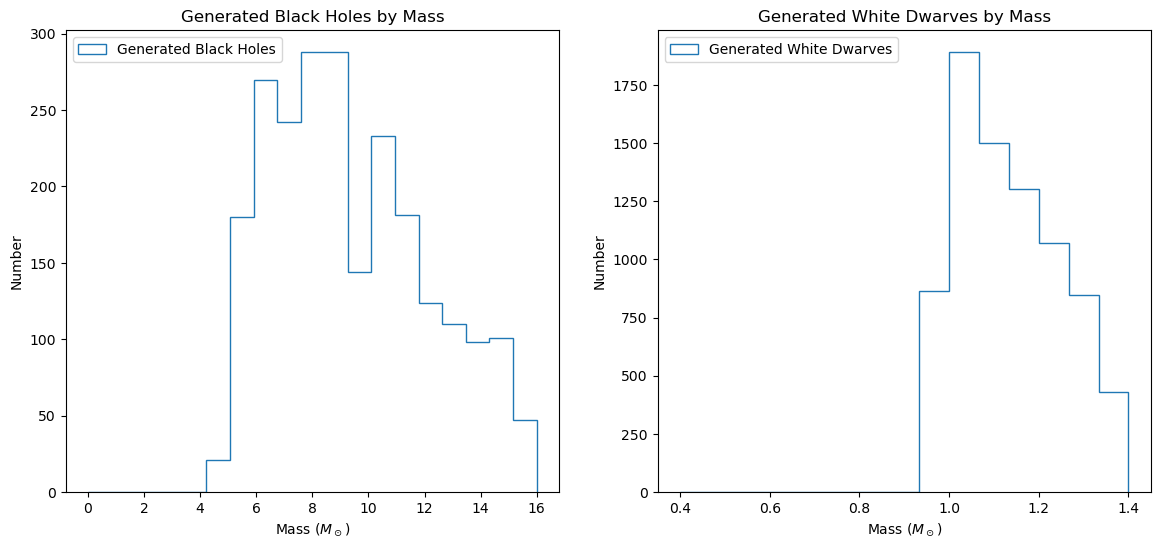

In [11]:
# Locate BHs, NSs and WDs
p_bh = np.where(k_out['phase'] == 103)[0]
#c_bh = np.where(k_comp['phase'] == 103)[0]
#k_bh = np.concatenate([p_bh, c_bh])
p_ns = np.where(k_out['phase'] == 102)[0]
#c_ns = np.where(k_comp['phase'] == 102)[0]
#k_ns = np.concatenate([p_ns, c_ns])
p_wd = np.where(k_out['phase'] == 101)[0]
#c_wd = np.where(k_comp['phase'] == 101)[0]
#k_wd = np.concatenate([p_wd, c_wd])

# Plot on histograms
bh_bins = np.linspace(0.01, 16, 20)
wd_bins = np.linspace(0.4, 1.4, 16)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.hist(k_out[p_bh]['mass_current'], histtype = 'step',
        bins = bh_bins, label = 'Generated Black Holes')
plt.title("Generated Black Holes by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(k_out[p_wd]['mass_current'], histtype = 'step',
        bins = wd_bins, label = 'Generated White Dwarves')
plt.title("Generated White Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

plt.show()

In [6]:
all_masses = np.concatenate([k_out['mass'], k_comp['mass']])
tot_mass = np.sum(all_masses)
print(tot_mass)

973669.0207942065


In [7]:
print(np.min(k_out['mass']))
print(np.min(k_comp['mass']))

0.07000000391702135
0.010000022844115403


In [ ]:
print("Current smallest mass of generated black holes: " + str(np.min(k_out[k_bh]['mass_current'])))
print("Current largest mass of generated black holes: " + str(np.max(k_out[k_bh]['mass_current'])))

In [ ]:
print('The cluster table contains these columns: {0}'.format(k_cluster.star_systems.keys()))

In [13]:
print(k_out[p_bh])

       mass        isMultiple     systemMass     ... metallicity m_hst_f153m
------------------ ---------- ------------------ ... ----------- -----------
 59.05436159479683      False  59.05436159479683 ...         0.0         nan
 39.55979231152168      False  39.55979231152168 ...         0.0         nan
18.241030351057457      False 18.241030351057457 ...         0.0         nan
 21.34571632826156      False  21.34571632826156 ...         0.0         nan
 25.73229556345863      False  25.73229556345863 ...         0.0         nan
 38.27638428342816      False  38.27638428342816 ...         0.0         nan
 29.70200219305832      False  29.70200219305832 ...         0.0         nan
               ...        ...                ... ...         ...         ...
104.95164061880804      False 104.95164061880804 ...         0.0         nan
19.927108168048903      False 19.927108168048903 ...         0.0         nan
51.756416056664165      False 51.756416056664165 ...         0.0         nan

In [12]:
print(k_out[p_bh]['mass'], k_out[p_bh]['mass_current'])

       mass       
------------------
 59.05436159479683
 39.55979231152168
18.241030351057457
 21.34571632826156
 25.73229556345863
 38.27638428342816
 29.70200219305832
               ...
104.95164061880804
19.927108168048903
51.756416056664165
  30.9405328260462
16.452556081467357
15.253386148271723
 34.00333629883476
Length = 2327 rows    mass_current   
------------------
  7.69101697945427
 14.37645768969197
 6.490426115488822
 7.738537786899665
 9.302666353833182
13.811546507105783
10.635261248769924
               ...
5.9065928872088955
 7.187073433524934
 9.426130388477304
11.054167247370941
 5.693090725172411
 5.119608907641256
 12.13042109233094
Length = 2327 rows


In [14]:
print("Initial mass of smallest generated black hole: " + str(np.min(k_out[p_bh]['mass'])))
print("Initial mass of largest generated black hole: " + str(np.max(k_out[p_bh]['mass'])))

Initial mass of smallest generated black hole: 15.003458139141888
Initial mass of largest generated black hole: 119.60497046926774
